In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [166]:
lstm_result = pd.read_csv('/content/drive/MyDrive/ADL final project/data/LSTM_prediction.csv', index_col=[0])
attention_result = pd.read_csv('/content/drive/MyDrive/ADL final project/data/attention_prediction.csv', index_col=[0])
vlstm_result = pd.read_csv('/content/drive/MyDrive/ADL final project/data/vlstm_output.csv', index_col=[0])
transformer_result = pd.read_csv('/content/drive/MyDrive/ADL final project/data/transformers_prediction.csv', index_col=[0])

In [167]:
attention_result.columns = ['attn_with_time', 'attn_wo_time']
lstm_result.columns = ['lstm_with_time', 'lstm_wo_time']
transformer_result.columns = ['transformer_with_time', 'transformer_wo_time']

In [168]:
df = pd.read_csv('/content/drive/MyDrive/ADL final project/data/final_input.csv', index_col = [0])


In [181]:
min_len = min(len(lstm_result), len(attention_result), len(vlstm_result), len(transformer_result))
print(min_len)
lstm_result = lstm_result[len(lstm_result)-min_len+1:]
attention_result = attention_result[len(attention_result)-min_len+1:]
vlstm_result = vlstm_result[len(vlstm_result)-min_len+1:]
transformer_result = transformer_result[len(transformer_result)-min_len+1:]

price = df[len(df)-min_len+1:]['Close']

lstm_result.index = np.arange(0,len(lstm_result))
attention_result.index = np.arange(0,len(attention_result))
vlstm_result.index = np.arange(0,len(vlstm_result))
transformer_result.index = np.arange(0,len(transformer_result))
price.index = np.arange(0,len(price))

assert len(lstm_result) == len(attention_result)

27587


In [171]:
merged = pd.concat([price,lstm_result,attention_result,vlstm_result,transformer_result], axis=1)
merged.drop(['y_true'],axis=1,inplace=True)
merged

,Close,lstm_with_time,lstm_wo_time,attn_with_time,attn_wo_time,vlstm_with_time,vlstm_without_time,transformer_with_time,transformer_wo_time
0,134.475,1,1,1,1,1,1,1,1
1,134.410,1,1,1,1,1,1,1,1
2,134.390,1,1,1,1,1,1,1,1
3,134.490,1,1,1,1,1,1,1,1
4,134.515,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
27584,122.185,0,0,0,0,1,1,0,0
27585,122.210,0,0,0,0,1,1,0,0
27586,122.235,0,0,0,0,1,1,1,0
27587,122.230,1,1,1,1,1,1,1,0


In [186]:
def initialize_trade():
  buying_flag = [0]
  selling_flag = [0]
  holding_flag = [1]
  inventory = [0]

  return buying_flag, selling_flag, holding_flag, inventory

def flag_append(i, flags, buying_flag, selling_flag, holding_flag, inventory):

  if flags == 'buying':
    buying_flag.append(1)
    selling_flag.append(0)
    holding_flag.append(0)
    inventory.append(1)
  
  elif flags == 'selling':
    buying_flag.append(0)
    selling_flag.append(1)
    holding_flag.append(0)
    inventory.append(0)

  elif flags == 'holding':
    buying_flag.append(0)
    selling_flag.append(0)
    holding_flag.append(1)
    if inventory[i-1] == 0:
      inventory.append(0)
    else:
      inventory.append(1)

  return buying_flag, selling_flag, holding_flag

def checking_returns(df, col):

  buying_flag, selling_flag, holding_flag, inventory = initialize_trade()
  pred_df = df.dropna()

  for i in range(1,len(pred_df[col])):

    cur_pred = pred_df[col].iloc[i-1]

    if inventory[i-1] == 0:
      if cur_pred == 1:
        buying_flag, selling_flag, holding_flag = flag_append(i,'buying', buying_flag, selling_flag, holding_flag,inventory)
      else:
        buying_flag, selling_flag, holding_flag = flag_append(i,'holding', buying_flag, selling_flag, holding_flag,inventory)
    else:
      if cur_pred == 1:
        buying_flag, selling_flag, holding_flag = flag_append(i,'holding', buying_flag, selling_flag, holding_flag,inventory)
      else:
        buying_flag, selling_flag, holding_flag = flag_append(i,'selling', buying_flag, selling_flag, holding_flag,inventory)
  
  for _ in range(2):
    buying_flag.pop(0)
    selling_flag.pop(0)
    holding_flag.pop(0)
    inventory.pop(0)

  if sum(buying_flag) == sum(selling_flag):
    buying_flag.append(0)
    selling_flag.append(0)
    holding_flag.append(1)
    inventory.append(0)

  else:
    buying_flag.append(0)
    selling_flag.append(1)
    holding_flag.append(0)
    inventory.append(0)

  buying_flag.append(0)
  selling_flag.append(0)
  holding_flag.append(1)
  inventory.append(0)

  pred_df['buying'] = buying_flag
  pred_df['holding'] = holding_flag
  pred_df['selling'] = selling_flag
  pred_df['inventory'] = inventory

  buying_df = pd.DataFrame()
  selling_df = pd.DataFrame()

  buying_df = pred_df[pred_df['buying']==1]['Close'].reset_index().drop(columns=['index']).rename(columns={"Close": "buying"})
  selling_df = pred_df[pred_df['selling']==1]['Close'].reset_index().drop(columns=['index']).rename(columns={"Close": "selling"})

  calculate_return_df = pd.DataFrame()
  calculate_return_df = pd.concat([selling_df, buying_df], axis=1)

  calculate_return_df['return'] = (calculate_return_df['selling']/calculate_return_df['buying'])
  #calculate_return_df['return'].cumprod().plot(label=col)

  return calculate_return_df['return'].cumprod().dropna().values[-1], pred_df, calculate_return_df


In [187]:
cum_return_lstm_time, lstm_with_time, lstm_with_time_return = checking_returns(merged, 'lstm_with_time')
cum_return_lstm_wo_time, lstm_wo_time, lstm_wo_time_return_df = checking_returns(merged, 'lstm_wo_time')
cum_return_attn_time, attn_with_time, attn_with_time_return_df = checking_returns(merged, 'attn_with_time')
cum_return_attn_wo_time, attn_wo_time, attn_wo_time_return_df = checking_returns(merged, 'attn_wo_time')
cum_return_vlstm_time, vlstm_with_time, vlstm_with_time_return_df = checking_returns(merged, 'vlstm_with_time')
cum_return_vlstm_wo_time, vlstm_without_time, vlstm_without_time_return_df = checking_returns(merged, 'vlstm_without_time')
cum_return_tfmr_time, transformer_with_time, transformer_with_time_return_df = checking_returns(merged, 'transformer_with_time')
cum_return_tfmr_wo_time, transformer_without_time, transformer_wo_time_return_df = checking_returns(merged, 'transformer_wo_time')



In [178]:
lstm_with_time[['Close','buying','holding','selling']]

,Close,buying,holding,selling
0,134.475,0,1,0
1,134.410,0,1,0
2,134.390,0,1,0
3,134.490,0,1,0
4,134.515,0,1,0
5,134.455,0,1,0
6,134.405,0,1,0
7,134.350,0,1,0
8,134.515,0,1,0
9,134.565,0,1,0


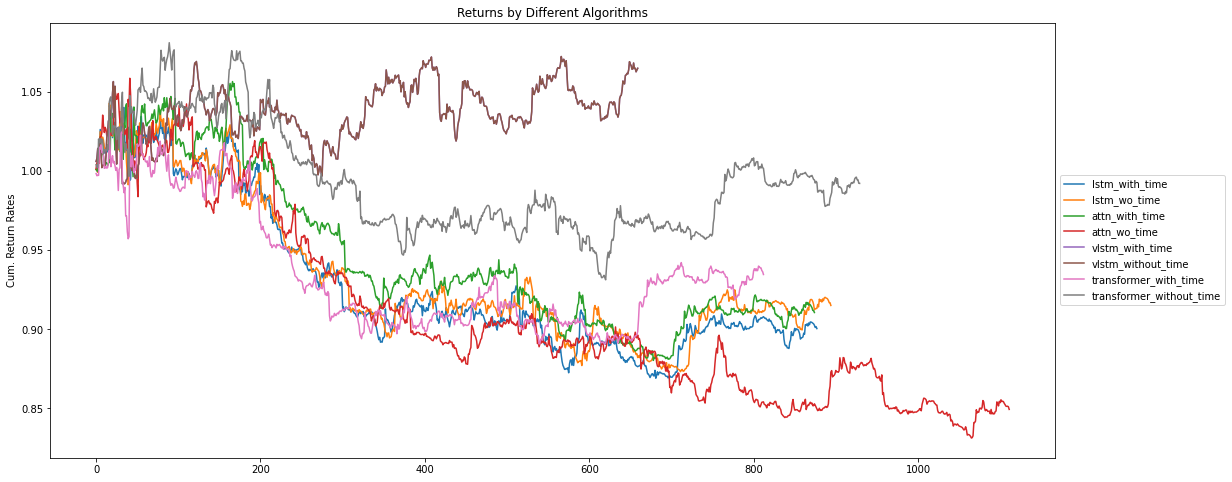

In [188]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111,  ylabel='Cum. Return Rates')

ax = lstm_with_time_return['return'].cumprod().plot(label='lstm_with_time')
ax = lstm_wo_time_return_df['return'].cumprod().plot(label='lstm_wo_time')
ax = attn_with_time_return_df['return'].cumprod().plot(label='attn_with_time')
ax = attn_wo_time_return_df['return'].cumprod().plot(label='attn_wo_time')
ax = vlstm_with_time_return_df['return'].cumprod().plot(label='vlstm_with_time')
ax = vlstm_without_time_return_df['return'].cumprod().plot(label='vlstm_without_time')
ax = transformer_with_time_return_df['return'].cumprod().plot(label='transformer_with_time')
ax = transformer_wo_time_return_df['return'].cumprod().plot(label='transformer_without_time')

ax.set_title('Returns by Different Algorithms')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) #here is the magic

In [154]:
import matplotlib.pyplot as plt

def plot_flags(df, title):
  fig = plt.figure(figsize=(18,8))
  ax1 = fig.add_subplot(111,  ylabel='Price in $')
  df['Close'].plot(ax=ax1, color='black', lw=2.)

  ax1.plot(df_lstm_train.loc[df_lstm_train.buying == 1.0].index, 
         df_lstm_train.Close[df_lstm_train.buying == 1.0],
         '^', markersize=10, color='r',alpha=0.4)
         
  ax1.plot(df_lstm_train.loc[df_lstm_train.selling == 1.0].index, 
         df_lstm_train.Close[df_lstm_train.selling == 1.0],
         'v', markersize=10, color='b',alpha=0.4)

  ax1.set_title(title)
  plt.show()  


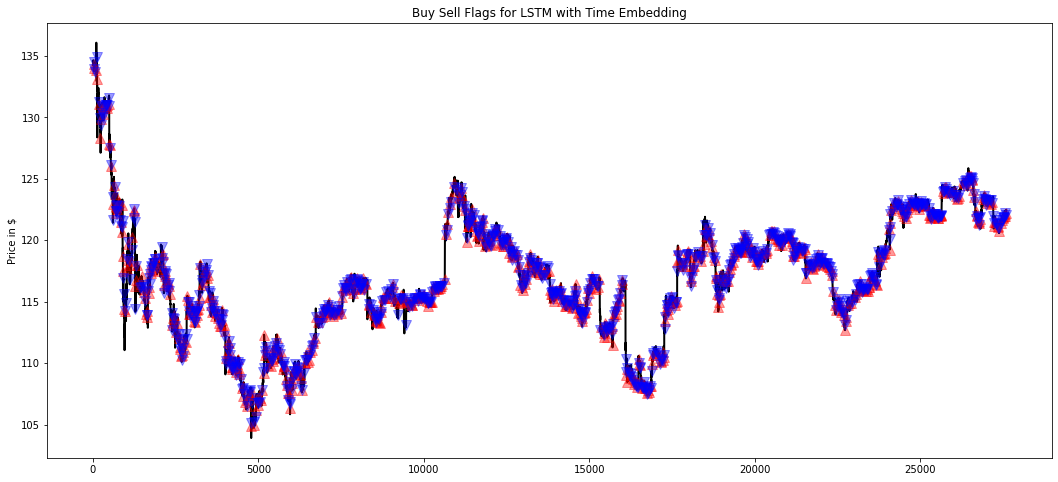

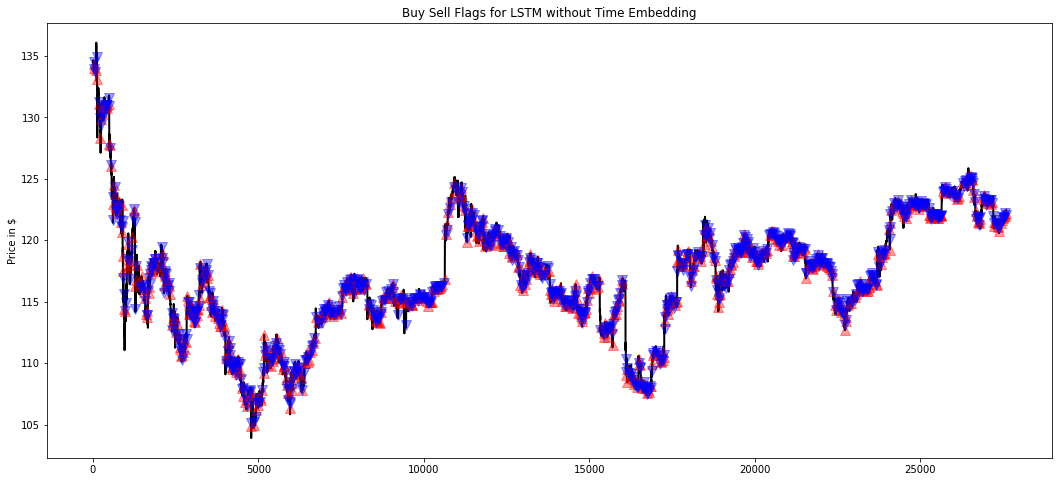

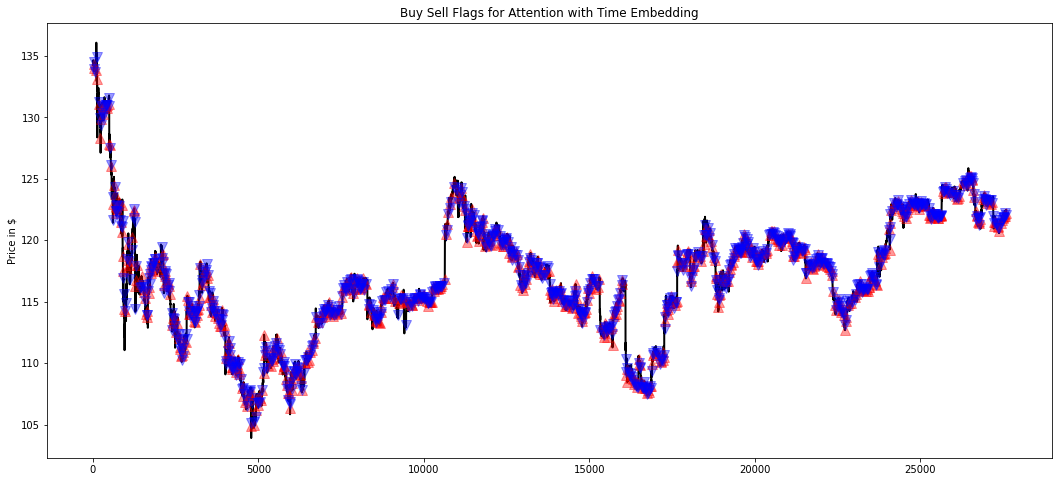

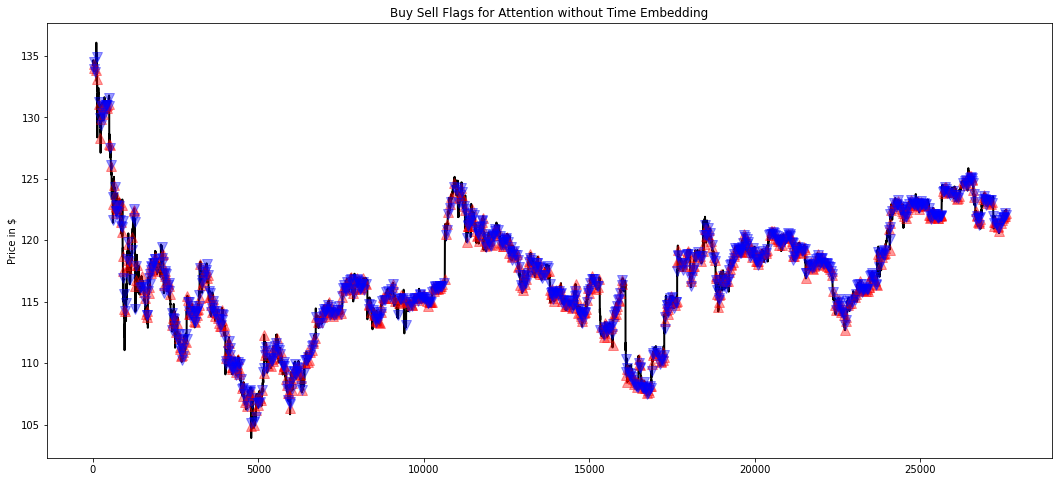

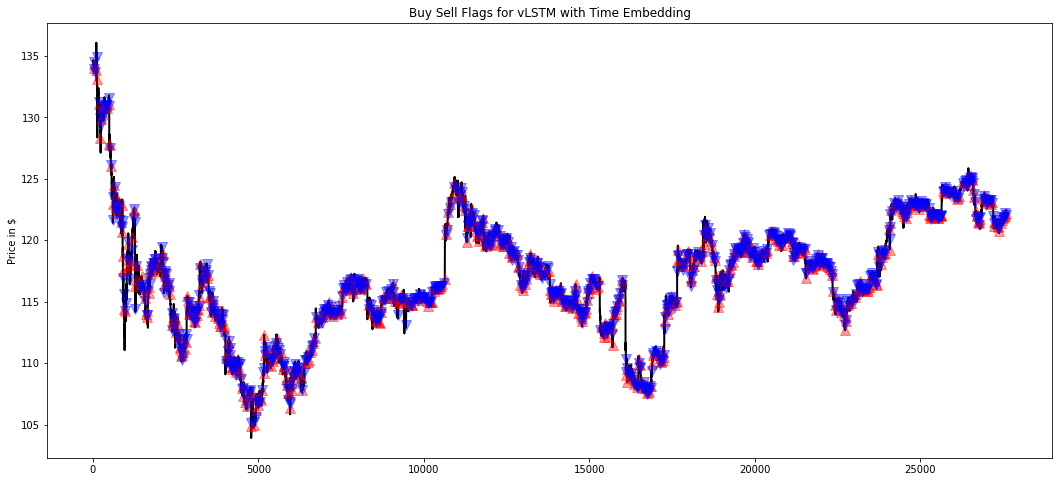

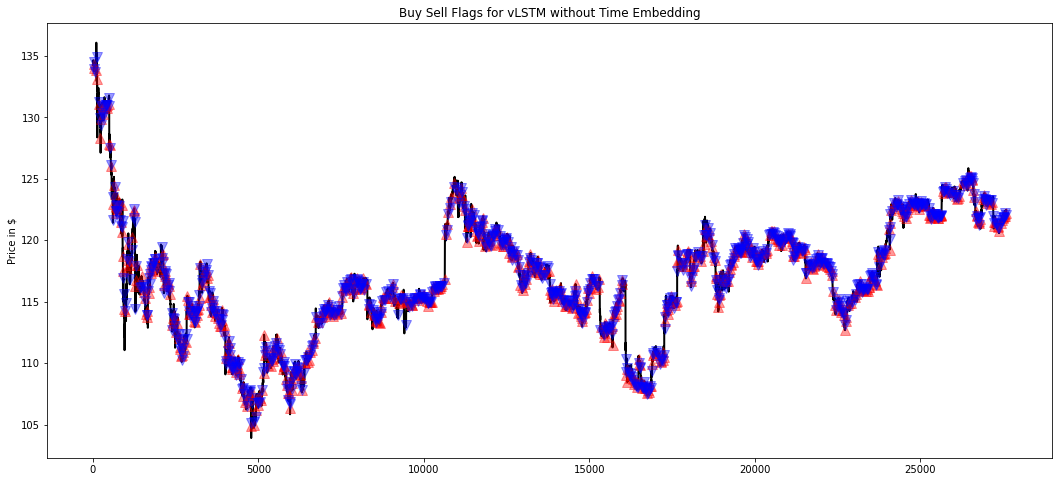

In [155]:
plot_flags(lstm_with_time, 'Buy Sell Flags for LSTM with Time Embedding')
plot_flags(lstm_wo_time, 'Buy Sell Flags for LSTM without Time Embedding')
plot_flags(attn_with_time, 'Buy Sell Flags for Attention with Time Embedding')
plot_flags(attn_wo_time, 'Buy Sell Flags for Attention without Time Embedding')
plot_flags(vlstm_with_time, 'Buy Sell Flags for vLSTM with Time Embedding')
plot_flags(vlstm_without_time, 'Buy Sell Flags for vLSTM without Time Embedding')
plot_flags(transformer_with_time, 'Buy Sell Flags for Transformer with Time Embedding')
plot_flags(transformer_without_time, 'Buy Sell Flags for Transformer without Time Embedding')


